!time kg download # after configuring Kaggle CLI, this will download the dataset  
!time unzip -q images_training_rev1.zip

In [1]:
!time unzip -q images_training_rev1.zip

8.34user 2.02system 0:10.39elapsed 99%CPU (0avgtext+0avgdata 3944maxresident)k
0inputs+1883320outputs (0major+999minor)pagefaults 0swaps


In [1]:
import pandas as pd
import zipfile


with zipfile.ZipFile('training_solutions_rev1.zip') as zfile:
    with zfile.open('training_solutions_rev1.csv') as f:
        df = pd.read_csv(f)
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [2]:
import numpy as np
import os


img_names = df['GalaxyID'].astype('str') + '.jpg'
labels = np.apply_along_axis(np.argmax, 1, df.iloc[:, 1:4].values)

np.random.seed(42)
train_val_test_split = np.random.choice(['train', 'val', 'test'], size=len(df), p=[0.6, 0.2, 0.2])

old_path = 'images_training_rev1/'
new_path = 'imgs/'

for folder_path in ['train', 'val', 'test']:
    for sub_path in set(labels):
        new_dir = new_path + folder_path + '/' + str(sub_path)
        if not os.path.isdir(new_dir):
            print('Making new directory: {}'.format(new_dir))
            os.makedirs(new_dir)

for image_name, dataset, label in zip(img_names, train_val_test_split, labels):
    try:
        os.rename(old_path + image_name, new_path + dataset + '/' + str(label) + '/' + image_name)
    except OSError:
        pass

In [3]:
from utils import *


def get_LeNet_model():
    inp = Input(shape=(3, 224, 224))
    x = Convolution2D(6, 5, 5, activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Convolution2D(16, 5, 5, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(120 * 10, activation='relu')(x) # not a conv layer
    x = Dense(84 * 10, activation='relu')(x) # used relu for faster training
    x = Dense(3, activation='softmax')(x)
    model = Model(inp, x)
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

train_batches = image.ImageDataGenerator().flow_from_directory(new_path + 'train/', target_size=(224, 224),
            class_mode='categorical', shuffle=True, batch_size=64)
val_batches = image.ImageDataGenerator().flow_from_directory(new_path + 'val/', target_size=(224, 224),
            class_mode='categorical', shuffle=False, batch_size=64)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Found 36964 images belonging to 3 classes.
Found 12383 images belonging to 3 classes.


In [11]:
inp = Input(shape=(3, 224, 224))
x = Convolution2D(32, 5, 5, activation='relu', subsample=(3, 3))(inp)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(256, 5, 5, activation='relu', subsample=(3, 3))(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(640, activation='relu')(x) # not a conv layer
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x) # used relu for faster training
x = BatchNormalization()(x)
x = Dense(3, activation='softmax')(x)
model = Model(inp, x)
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 32, 74, 74)    2432        input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 32, 74, 74)    64          convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 32, 37, 37)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [ ]:
model.fit_generator(train_batches, train_batches.N, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

In [ ]:
# glorot initialization?
# sigmoid vs relu
# increase dense neurons or more filters
# learning rate
# want to overfit; ideally should be more accurate than 50%
# not enough filters!
# no dropout
# no batchnorm

In [42]:
%%time

LeNet = get_LeNet_model()
LeNet.optimizer.lr = 0.001
LeNet.fit_generator(train_batches, train_batches.N, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
36964/36964 [==============================] - 575s - loss: 9.1652 - acc: 0.4311 - val_loss: 9.0763 - val_acc: 0.4369
CPU times: user 10min 44s, sys: 1min 4s, total: 11min 48s
Wall time: 9min 40s


In [59]:
#LeNet.layers[-1].get_weights()

array([[ 0.0452, -0.0691,  0.016 ],
       [-0.0406,  0.0386,  0.0604],
       [-0.052 , -0.0454, -0.0131],
       ..., 
       [ 0.0398,  0.0715, -0.0059],
       [-0.062 ,  0.0464, -0.0575],
       [-0.0291, -0.0295, -0.0556]], dtype=float32)

In [45]:
LeNet.predict(train_batches.next()[0])[:10]

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]], dtype=float32)

In [5]:
%%time

LeNet.optimizer.lr = 0.1
LeNet.fit_generator(train_batches, train_batches.N // 10, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
3712/3696 [==============================] - 190s - loss: 0.7125 - acc: 0.5348 - val_loss: 0.6930 - val_acc: 0.5621
CPU times: user 3min 21s, sys: 14.5 s, total: 3min 35s
Wall time: 3min 10s


In [15]:
LeNet.predict(train_batches.next()[0])

array([[ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5805,  0.0008],
       [ 0.4186,  0.5806,  0

In [16]:
%%time

LeNet.optimizer.lr = 0.1
LeNet.fit_generator(train_batches, train_batches.N // 10, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/1
3712/3696 [==============================] - 190s - loss: 0.6989 - acc: 0.5506 - val_loss: 0.6977 - val_acc: 0.5621
CPU times: user 3min 23s, sys: 14.3 s, total: 3min 37s
Wall time: 3min 10s


In [18]:
#LeNet.predict(train_batches.next()[0])[:20]

In [17]:
%%time
from glob import glob

val_batches = image.ImageDataGenerator().flow_from_directory(new_path + 'val/', target_size=(224, 224),
            class_mode='categorical', shuffle=False, batch_size=64)

num_val_pictures = len(glob('imgs/val/*/*'))
pics, pic_labels = [], []


while len(pics) < num_val_pictures:
    x, y = val_batches.next()
    pics.extend(x)
    pic_labels.extend(y)

Found 12383 images belonging to 3 classes.


In [31]:
val_batches = image.ImageDataGenerator().flow_from_directory(new_path + 'val/', target_size=(224, 224),
            class_mode='categorical', shuffle=False, batch_size=64)

predictions = LeNet.predict_generator(val_batches, val_samples=val_batches.N)

Found 12383 images belonging to 3 classes.


In [33]:
Counter(np.apply_along_axis(np.argmax, 1, predictions))
# something wrong. always predicting class 0

Counter({0: 12383})

In [34]:
%%time
from collections import Counter

print(np.array(pics).shape)
print(Counter([np.argmax(tup) for tup in pic_labels]))

(12383, 3, 224, 224)
Counter({1: 6961, 0: 5410, 2: 12})
CPU times: user 2.25 s, sys: 3.25 s, total: 5.5 s
Wall time: 5.5 s


In [6]:
%%time
LeNet.optimizer.lr = 0.01
LeNet.fit_generator(train_batches, train_batches.N, nb_epoch=2, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)
LeNet.optimizer.lr = 0.001
LeNet.fit_generator(train_batches, train_batches.N, nb_epoch=2, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/2
36964/36964 [==============================] - 553s - loss: 9.1457 - acc: 0.4326 - val_loss: 9.0763 - val_acc: 0.4369
Epoch 2/2
36964/36964 [==============================] - 547s - loss: 9.1575 - acc: 0.4319 - val_loss: 9.0763 - val_acc: 0.4369
Epoch 1/2
36964/36964 [==============================] - 555s - loss: 9.1357 - acc: 0.4332 - val_loss: 9.0763 - val_acc: 0.4369
Epoch 2/2
36964/36964 [==============================] - 545s - loss: 9.1444 - acc: 0.4327 - val_loss: 9.0763 - val_acc: 0.4369


In [7]:
LeNet.optimizer.lr = 0.1
LeNet.fit_generator(train_batches, train_batches.N, nb_epoch=2, 
                    validation_data=val_batches, nb_val_samples=val_batches.N)

Epoch 1/2
36964/36964 [==============================] - 549s - loss: 9.1601 - acc: 0.4317 - val_loss: 9.0763 - val_acc: 0.4369
Epoch 2/2
36964/36964 [==============================] - 544s - loss: 9.1561 - acc: 0.4319 - val_loss: 9.0763 - val_acc: 0.4369


In [ ]:
!rm -rf images_training_rev1/
!rm -rf imgs

In [10]:
"""
from vgg16 import Vgg16
import os

path = '../courses/deeplearning1/nbs/data/distracted_driver/imgs/' # change for respective data set
model_path = '../courses/deeplearning1/nbs/data/distracted_driver/models/' # change for respective data set
batch_size = 64

if not os.path.isdir(model_path): # make validation folder
    print('Making new directory: {}'.format(model_path))
    os.mkdir(model_path)

vgg = Vgg16() # imagenet weights already loaded
# during training, shuffle should be set to true. Or else, it will likely receive training on the same class consecutively
train_batches = vgg.get_batches(path + 'train/', batch_size=batch_size, shuffle=True)
val_batches = vgg.get_batches(path + 'val/', batch_size=batch_size * 2, shuffle=False)
vgg.finetune(train_batches) # optimizer is Adam
"""

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [3]:
from vgg16 import Vgg16

new_path = 'imgs/'
batch_size = 64


vgg = Vgg16() # imagenet weights already loaded
# during training, shuffle should be set to true. Or else, it will likely receive training on the same class consecutively
train_batches = vgg.get_batches(new_path + 'train/', batch_size=batch_size, shuffle=True)
val_batches = vgg.get_batches(new_path + 'val/', batch_size=batch_size * 2, shuffle=False)
vgg.finetune(train_batches) # optimizer is Adam

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Found 36964 images belonging to 3 classes.
Found 12383 images belonging to 3 classes.


In [4]:
vgg.model.optimizer.lr.set_value(0.01)

In [5]:
vgg.fit(train_batches, val_batches, nb_epoch=1)

Epoch 1/1
36964/36964 [==============================] - 1501s - loss: 1.7702 - acc: 0.6699 - val_loss: 1.3586 - val_acc: 0.6835


In [ ]:
vgg.fit(train_batches, val_batches, nb_epoch=1)

Epoch 1/1
36900/36964 [============================>.] - ETA: 1s - loss: 2.0557 - acc: 0.6796

In [70]:
vgg.model.optimizer.lr.set_value(0.001)

array(0.0010000000474974513, dtype=float32)

In [ ]:
vgg.fit(train_batches, val_batches, nb_epoch=1)

In [ ]:
# what does vgg.finetune do? how to do a mixiterator type of thing to get probabilistic inputs

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.
  0%|          | 0/185 [00:00<?, ?it/s]

Found 36964 images belonging to 3 classes.


  0%|          | 0/62 [00:00<?, ?it/s]

Found 12383 images belonging to 3 classes.


100%|██████████| 62/62 [08:38<00:00,  8.05s/it]


CPU times: user 51min 20s, sys: 3min 1s, total: 54min 21s
Wall time: 34min 55s


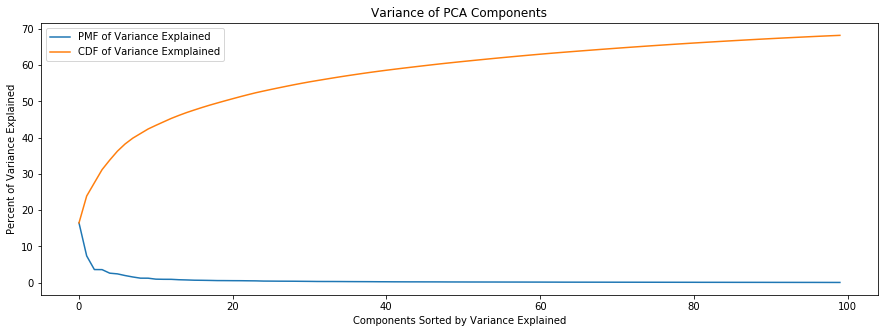

In [1]:
%%time
from utils import *
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
import cPickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


batch_size = 200
iPCA = IncrementalPCA(n_components=batch_size // 2)

for folder in ['train', 'val']: # using training and validation set for finding PCA components 
    image_generator = image.ImageDataGenerator().flow_from_directory('imgs/' + folder, target_size=(224, 224),
                class_mode='categorical', shuffle=True, batch_size=batch_size)
    for i in tqdm(xrange(image_generator.N // batch_size + 1)):
        images, classes = image_generator.next()
        iPCA.partial_fit(images.reshape((len(images), -1)))
    
with open('iPCA.pkl', 'wb') as f:
    pkl.dump(iPCA, f)

plt.figure(figsize=(15, 5))
plt.plot(iPCA.explained_variance_ratio_ * 100, label='PMF of Variance Explained')
plt.plot(np.cumsum(iPCA.explained_variance_ratio_) * 100, label='CDF of Variance Exmplained')
plt.legend()
plt.xlabel('Components Sorted by Variance Explained')
plt.ylabel('Percent of Variance Explained')
plt.title('Variance of PCA Components')

In [1]:
%%time
from utils import *
import cPickle as pkl
from tqdm import tqdm


def transform_X_with_PCA(image_generator, iPCA): # generator must not be shuffled
    X_transformed = []
    y_labels = []
    for i in xrange(image_generator.N // image_generator.batch_size + 1):
        images, classes = image_generator.next()
        X_transformed.append(iPCA.transform(images.reshape((len(images), -1))))
        y_labels.append(classes)
    X_transformed = np.concatenate(X_transformed)
    y_labels = np.concatenate(y_labels)
    # need to truncate if over sampled by 1 iteration
    return X_transformed[:image_generator.N], y_labels[:image_generator.N]


with open('iPCA.pkl', 'rb') as f:
    iPCA = pkl.load(f)

new_path = 'imgs/'
batch_size = 300
for folder in tqdm(['train', 'val', 'test']):
    # transforming images to lower dimensionality
    print('\nData set: {}'.format(folder))
    image_generator = image.ImageDataGenerator().flow_from_directory(new_path + folder, 
            target_size=(224, 224), class_mode='categorical', shuffle=False, 
            batch_size=batch_size)
    X_transformed, y_labels = transform_X_with_PCA(image_generator, iPCA)
    
    data_transformed = {'image_names': image_generator.filenames, 'X_transformed': 
                    X_transformed, 'y_labels': np.argmax(y_labels, axis=1)}

    # performing sanity check to make sure image names and image data are aligned by index
    print('All arrays have the same length: {}'.format(
            len(data_transformed['X_transformed']) == 
                len(data_transformed['y_labels']) == 
                len(data_transformed['image_names'])))
    class_labels = np.array([fname[0] for fname in data_transformed['image_names']])
    print('All image classes appear to match up: {}'.format(
            (data_transformed['y_labels'].astype('str') == class_labels).all()))

    # save transformed vectors to disk
    with open(folder + '_transformed.pkl', 'wb') as f:
        pkl.dump(data_transformed, f)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.
  0%|          | 0/3 [00:00<?, ?it/s]


Data set: train
Found 36964 images belonging to 3 classes.
All arrays have the same length: True
All image classes appear to match up: True


 33%|███▎      | 1/3 [07:30<15:00, 450.10s/it]


Data set: val
Found 12383 images belonging to 3 classes.
All arrays have the same length: True
All image classes appear to match up: True


 67%|██████▋   | 2/3 [10:00<06:00, 360.33s/it]


Data set: test
Found 12231 images belonging to 3 classes.
All arrays have the same length: True
All image classes appear to match up: True


100%|██████████| 3/3 [12:29<00:00, 296.90s/it]

CPU times: user 13min 22s, sys: 37.9 s, total: 14min
Wall time: 12min 51s


In [1]:
%%time
import cPickle as pkl
import numpy as np


with open('train_transformed.pkl', 'rb') as f:
    train_transformed = pkl.load(f)
with open('val_transformed.pkl', 'rb') as f:
    val_transformed = pkl.load(f)
with open('test_transformed.pkl', 'rb') as f:
    test_transformed = pkl.load(f)

X_transformed = train_transformed['X_transformed']
y_labels = train_transformed['y_labels']

CPU times: user 6.09 s, sys: 164 ms, total: 6.25 s
Wall time: 6.26 s


In [2]:
%%time
# Grid Search over Random Forest Hyperparameters using Stratified K-Fold Cross Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


rf = RandomForestClassifier(n_jobs=-2, oob_score=True, random_state=42)
param_grid = {
            "n_estimators": [50, 100], 
            'max_depth': [5, 7, 9]
            }
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=kfold, n_jobs=-2, scoring='f1_weighted', verbose=2)
grid_search.fit(X_transformed, y_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=50, max_depth=5 ....................................
[CV] n_estimators=50, max_depth=5 ....................................
[CV] n_estimators=50, max_depth=5 ....................................


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..................... n_estimators=50, max_depth=5, total=   7.7s
[CV] n_estimators=50, max_depth=5 ....................................
[CV] ..................... n_estimators=50, max_depth=5, total=   7.8s
[CV] n_estimators=50, max_depth=5 ....................................
[CV] ..................... n_estimators=50, max_depth=5, total=   7.9s
[CV] n_estimators=100, max_depth=5 ...................................
[CV] ..................... n_estimators=50, max_depth=5, total=   7.6s
[CV] n_estimators=100, max_depth=5 ...................................
[CV] ..................... n_estimators=50, max_depth=5, total=   8.0s
[CV] n_estimators=100, max_depth=5 ...................................
[CV] .................... n_estimators=100, max_depth=5, total=  14.8s
[CV] n_estimators=100, max_depth=5 ...................................
[CV] .................... n_estimators=100, max_depth=5, total=  14.9s
[CV] n_estimators=100, max_depth=5 ...................................
[CV] .

[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed:  2.6min finished


CPU times: user 37.3 s, sys: 96 ms, total: 37.4 s
Wall time: 2min 46s


In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
    recall_score, f1_score, confusion_matrix, auc, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
    
    
def print_metrics(y_actual, y_predict, average='weighted'):
    """Prints multiple metrics"""
    print "Accuracy:", (y_predict == y_actual).mean()
    print "Precision:", precision_score(y_actual, y_predict, average=average)
    print "Recall:", recall_score(y_actual, y_predict, average=average)
    print "F1-score:", f1_score(y_actual, y_predict, average=average)
    
print('Best hyperparameters: {}\n'.format(grid_search.best_params_))
print('Performance on Training Set')
print(confusion_matrix(y_labels, 
    grid_search.best_estimator_.predict(X_transformed)))
print_metrics(y_labels, grid_search.predict(X_transformed))

print('\nPerformance on Validation Set')
print(confusion_matrix(val_transformed['y_labels'], 
    grid_search.best_estimator_.predict(val_transformed['X_transformed'])))
print_metrics(val_transformed['y_labels'], 
    grid_search.predict(val_transformed['X_transformed']))

Best hyperparameters: {'n_estimators': 100, 'max_depth': 9}

Performance on Training Set
[[11711  4270     0]
 [ 2060 18887     0]
 [   12    23     1]]
Accuracy: 0.827724272265
Precision: 0.829960912159
Recall: 0.827724272265
F1-score: 0.825292770111

Performance on Validation Set
[[3604 1806    0]
 [ 945 6016    0]
 [   3    9    0]]
Accuracy: 0.776871517403
Precision: 0.777756096571
Recall: 0.776871517403
F1-score: 0.77336414643


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
grid_search.

0.76639855797943002

In [9]:
grid_search.cv_results_

{'mean_fit_time': array([  6.30889638,  12.57859763,   8.17774224,  16.25102099,
          9.49378943,  19.28782105]),
 'mean_score_time': array([ 0.12158561,  0.19596569,  0.16161672,  0.23313157,  0.24655962,
         0.19073733]),
 'mean_test_score': array([ 0.74469066,  0.74793528,  0.75887779,  0.7610579 ,  0.76639856,
         0.76633565]),
 'mean_train_score': array([ 0.76446281,  0.76693921,  0.79781177,  0.80087331,  0.83839572,
         0.83964319]),
 'param_max_depth': masked_array(data = [5 5 7 7 9 9],
              mask = [False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50 100 50 100 50 100],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 5, 'n_estimators': 50},
  {'max_depth': 5, 'n_estimators': 100},
  {'max_depth': 7, 'n_estimators': 50},
  {'max_depth': 7, 'n_estimators': 100},
  {'max_depth': 9, 'n_estimators': 50},
  {'max_depth': 9, 'n_estimator

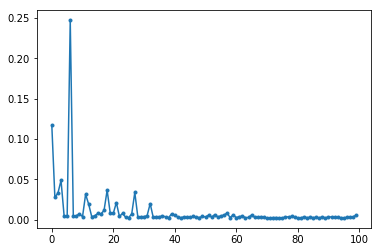

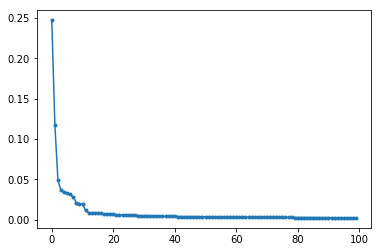

In [4]:
plt.plot(grid_search.best_estimator_.feature_importances_, marker='.')
plt.show()
plt.plot(sorted(grid_search.best_estimator_.feature_importances_)[::-1], marker='.')